# &#x2699; Thermal activation: Kramers' problem


Let us consider a particle in a double well potential.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


class DoubleWell:
    def __init__(self, loc=1, barrier=1):
        self.loc = loc
        self.barrier = barrier
        self.a = 2 * self.barrier / self.loc**2
        self.b = 0.5 * self.a / self.loc**2

    def V(self, x):
        return -self.a * x**2 + self.b * x**4 + self.barrier

    def F(self, x):
        return 2.0 * self.a * x - 4.0 * self.b * x**3


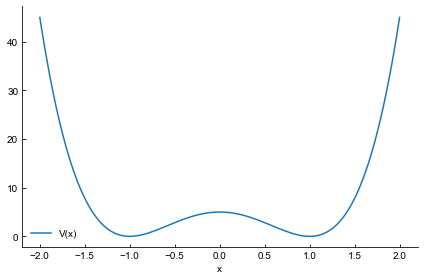

In [14]:
x = np.linspace(-2, 2, 1000)
barrier, loc = 5.0, 1.0
double_well = DoubleWell(loc=loc, barrier=barrier)
df = pd.DataFrame.from_dict({"x": x, "V(x)": double_well.V(x)})
df.plot(x="x", y="V(x)")
pass


We can use Ermak's algorithm to simulate a particle within the double well potential.

In [15]:
# Ermak algorithm
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import numba as nb


# @nb.njit  # Numba speedup. Comment if needed.
def ermak_external_potential(
    potential,
    total_time,
    npart=1000,
    ndims=1,
    friction=1.0,
    T=1.0,
    dt=0.04,
):
    nsteps = int(total_time / dt)
    # Fluctuation dissipation relation
    D = T / friction
    width = (2 * D * dt) ** 0.5

    # Overdamped Brownian dynamics
    positions = np.zeros((nsteps, npart, ndims))
    msd = np.zeros(nsteps)
    for i in range(1, nsteps):
        # Store MSD
        # msd[i] = np.sum(positions**2) / npart

        # Integration step
        # for position in positions:
        noise = np.random.normal(0.0, width, (npart, ndims))
        # print(i,noise)
        force = potential.F(positions[i - 1])

        positions[i] = positions[i - 1] + noise + force * dt / friction

    time = np.arange(nsteps) * dt
    return time, positions


We choose to work in one dimension and to simulate $N=100$ indipendent particles for a relatively large barrier $\Delta U=5 k_B T $=. The trajectories illustrate the phenomenon of bistability, where a particle resides for a long in one basin and then occasinally transitions to the other.

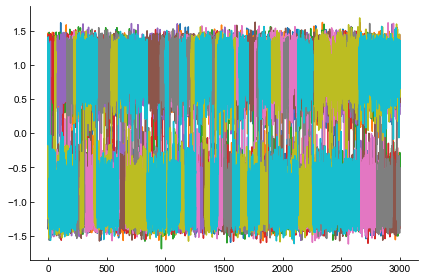

In [16]:
ndims = 1
npart = 100
friction = 5.0
dt = 0.04

time, pos = ermak_external_potential(
    double_well,
    total_time=3000.0,
    npart=npart,
    ndims=ndims,
    friction=friction,
    T=1.0,
    dt=dt,
)

for p in range(10):
    plt.plot(time, pos[:, p, :])


Since the two basins are completely symmetric, they are **equiprobable**:

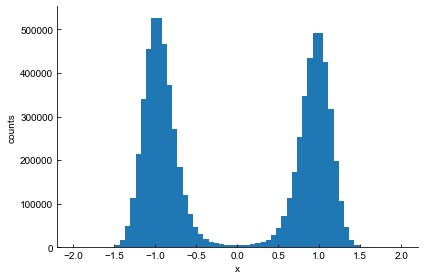

In [17]:
plt.hist(pos.ravel(), bins=np.linspace(-2, 2, 64))
plt.xlabel("x"), plt.ylabel("counts")
pass


## Autocorrelations and transition time

To characterise the transition, we can compute the estimator of the autocorrelation function at the $k$-th time lag of the discrete series $X_t$

$$\begin{equation}
{\rm ACF}(k)=\frac{1}{(n-k) \sigma^2} \sum_{t=1}^{n-k}\left(X_t-\mu\right)\left(X_{t+k}-\mu\right)
\end{equation}
$$

In particular, we take its average over the $N$ realisations

$$\langle \rm{ACF}\rangle(t) = \dfrac{1}{N}\sum_{i=1}^{N} {\rm ACF}_i(t)$$

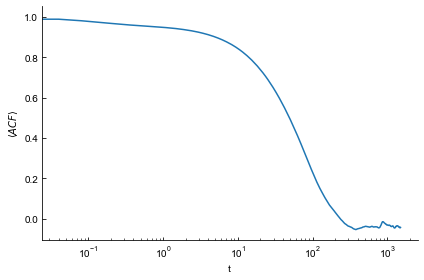

In [18]:
from statsmodels.tsa import stattools

maxlag = pos.shape[0] // 2
autocorrs = [stattools.acf(pos[:, p, :], nlags=maxlag) for p in range(pos.shape[1])]
times = dt * np.arange(maxlag + 1)
plt.semilogx(times, np.mean(autocorrs, axis=0))
plt.xlabel("t"), plt.ylabel(r"$\langle ACF\rangle$")
pass


Notice also that the **variance** of teh autocorrelation time peaks at large times.

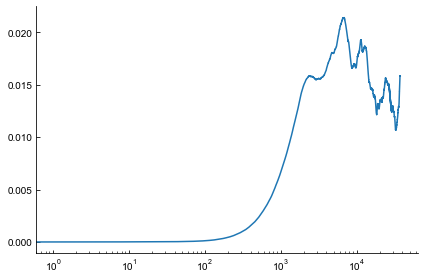

In [19]:
plt.plot(np.var(autocorrs, axis=0))
plt.xscale("log")


## Arrhenius behaviour

We can explore how the relaxation depends on the height of teh energy barrier between the two basins by systematically varying the energy barrier and measuring  a characteristic **relaxation time**. By convention, we take $\tau$ such that

$$ \langle {\rm ACF}\rangle(\tau) = 1/e$$

We define a function to extract such time

In [20]:
def transition_time(
    barrier, loc=1, total_time=3000, dt=0.04, T=1.0, friction=5.0, npart=100
):
    double_well = DoubleWell(loc=loc, barrier=barrier)
    time, pos = ermak_external_potential(
        double_well,
        total_time=total_time,
        npart=npart,
        ndims=1,
        friction=friction,
        T=T,
        dt=dt,
    )
    maxlag = pos.shape[0] // 2
    autocorrs = [stattools.acf(pos[:, p, :], nlags=maxlag) for p in range(pos.shape[1])]
    times = np.arange(maxlag + 1) * dt
    # crossing of 1/e
    mean_autocorr = np.mean(autocorrs, axis=0)
    tau = times[mean_autocorr < np.exp(-1)][0]
    return tau, times, mean_autocorr


And scan through a list of possible barrier values (logarithmically spaced).

In [21]:
barrier_lo, barrier_hi = 1.0, 7.0
nbarrier = 5
barriers = np.logspace(np.log10(barrier_lo), np.log10(barrier_hi), nbarrier, base=10)
taus = []
for barrier in barriers:
    tau, t, acf = transition_time(barrier)
    taus.append(tau)


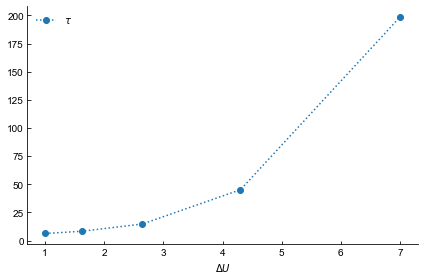

In [22]:
df = pd.DataFrame.from_dict({"$\Delta U$": barriers, r"$\tau$": taus})
df.plot(x="$\Delta U$", y=r"$\tau$", style=":o")
pass


The relaxationtime increaes rapidly. In fact, it increases **expontnentially**

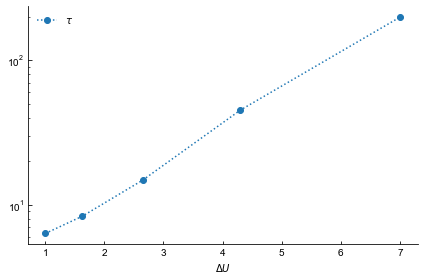

In [23]:
df.plot(x="$\Delta U$", y=r"$\tau$", style=":o", logy=True)
pass


This is an example of so-called **Arrhenius** relaxation

$$\begin{equation}
\tau \propto \exp[\Delta U/k_BT]
\end{equation}$$